In [1]:
import warnings
warnings.filterwarnings('ignore')

# Approche classique: embeddings de mots

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("./data/train_df.csv", index_col=0)
test_df = pd.read_csv("./data/test_df.csv", index_col=0)

In [4]:
train_df.shape

(3395, 11)

In [5]:
test_df.shape

(1456, 11)

In [6]:
y_train = train_df["target"]
y_test = test_df["target"]

### Embeddings de comptage des mots

En réalisant les embeddings de façon indépendante sur le jeu de train et de test on s'assure qu'il n'y a pas de fuite de données et que l'appréciation de performance du modèle ne sera pas biaisée. Cependant il y a un fort risque d'avoir des OOV lors du test.

In [7]:
train_df .head()#["preprocessed_text"].isna().sum()

,target,ids,date,flag,user,text,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,sia_sentiment
293041,0,1996195392,Mon Jun 01 14:41:09 PDT 2009,NO_QUERY,Matik72,@geekandahalf Just found out via a tweet and q...,<mention> Just found out via a tweet and quite...,"['<', 'mention', '>', 'Just', 'found', 'out', ...",< mention > found via tweet quite sad well wa...,"['<', 'mention', '>', 'found', 'via', 'tweet',...",0
280462,0,1992058944,Mon Jun 01 08:07:47 PDT 2009,NO_QUERY,chrys,*Two* plane crashes?! A good start for a month...,Plane crashes?! A good start for a month in w...,"['Plane', 'crashes', '?', '!', 'A', 'good', 's...",plane crash ? ! good start month presumably ta...,"['plane', 'crash', '?', '!', 'good', 'start', ...",1
1181323,1,1982066106,Sun May 31 10:27:31 PDT 2009,NO_QUERY,jbigga,What's your weight in killograms??? Twitter me...,What's your weight in killograms?? Twitter me ...,"['What', ""'s"", 'your', 'weight', 'in', 'killog...",'s weight killograms ? ? twitter answer ! ! wa...,"[""'s"", 'weight', 'killograms', '?', '?', 'twit...",1
308021,0,2000603503,Mon Jun 01 22:29:55 PDT 2009,NO_QUERY,Bobbistarr,Very scared for the people on the Air France f...,Very scared for the people on the Air France f...,"['Very', 'scared', 'for', 'the', 'people', 'on...",scared people air france flight,"['scared', 'people', 'air', 'france', 'flight']",0
378170,0,2052053534,Fri Jun 05 23:31:28 PDT 2009,NO_QUERY,lauralovesart,@markdavidson okay...cause yeah right now ther...,<mention> okay.cause yeah right now there are ...,"['<', 'mention', '>', 'okay.cause', 'yeah', 'r...",< mention > okaycause yeah right 4 plugins wo ...,"['<', 'mention', '>', 'okaycause', 'yeah', 'ri...",1


#### CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
train_count_sparse = count_vectorizer.fit_transform(train_df['preprocessed_text'])

test_count_sparse = count_vectorizer.transform(test_df['preprocessed_text'])


In [9]:
# # Précaution à prendre avec les matrices creuses
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
# train_count_scaled = scaler.fit_transform(train_count_sparse)
# test_count_scaled = scaler.fit_transform(test_count_sparse)

In [10]:
import scipy.sparse

train_count = pd.DataFrame.sparse.from_spmatrix(train_count_sparse, columns=count_vectorizer.get_feature_names_out())

test_count = pd.DataFrame.sparse.from_spmatrix(test_count_sparse, columns=count_vectorizer.get_feature_names_out())



In [11]:
from scipy.sparse import csr_matrix, hstack
train_count["target"] = y_train.values
test_count["target"] = y_test.values

### Modélisation des embeddings : test rapides avec Pycaret

In [12]:
# pip install pycaret[full]

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data=train_count, target='target', test_data=test_count, session_id = 123, index=False, use_gpu=True)

In [15]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [16]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [17]:
# compare baseline models and returns the best 6 ones
best_models = compare_models(sort='Precision', n_select=6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7131,0.7888,0.7252,0.7070,0.7156,0.4263,0.4269,5.3940
gbc,Gradient Boosting Classifier,0.6769,0.7644,0.6318,0.6932,0.6607,0.3536,0.3553,8.0600
ridge,Ridge Classifier,0.6966,0.7587,0.7057,0.6927,0.6986,0.3933,0.3940,5.5090
svm,SVM - Linear Kernel,0.6928,0.7567,0.7010,0.6904,0.6941,0.3857,0.3874,5.4760
et,Extra Trees Classifier,0.7119,0.7908,0.7696,0.6896,0.7269,0.4241,0.4276,6.4270
lightgbm,Light Gradient Boosting Machine,0.6969,0.7752,0.7199,0.6868,0.7025,0.3940,0.3950,5.7150
rf,Random Forest Classifier,0.7099,0.7904,0.7807,0.6839,0.7286,0.4201,0.4250,6.1500
catboost,CatBoost Classifier,0.7093,0.7817,0.7843,0.6817,0.7289,0.4189,0.4245,33.6230
dt,Decision Tree Classifier,0.6501,0.6538,0.6844,0.6395,0.6610,0.3003,0.3012,5.6340
ada,Ada Boost Classifier,0.6624,0.7498,0.7961,0.6300,0.6976,0.3255,0.3469,6.6170


In [19]:
# Sélection manuelle de modèles pour stacking
logistic_model = best_models[0]  # Logistic Regression 
extra_trees_model = best_models[4]  # Extra Trees Classifier 
gradient_boost_model = best_models[1]  # CatBoost Classifier 

In [20]:
# Construire le modèle Stacked avec ces modèles (on peut aussi créer des modèles lr = create_model("lr"))
stacked_model = stack_models([logistic_model, gradient_boost_model, extra_trees_model])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7382,0.8183,0.7515,0.7299,0.7405,0.4765,0.4767
1,0.6912,0.7894,0.7456,0.6702,0.7059,0.3827,0.3851
2,0.7294,0.7907,0.7988,0.6995,0.7459,0.4593,0.4639
3,0.7176,0.8008,0.6824,0.7342,0.7073,0.4353,0.4364
4,0.6853,0.7853,0.7235,0.6721,0.6969,0.3706,0.3717
5,0.7257,0.8104,0.7751,0.7043,0.7380,0.4515,0.4538
6,0.7198,0.7795,0.7219,0.7176,0.7198,0.4395,0.4395
7,0.7699,0.8652,0.7811,0.7630,0.7719,0.5399,0.5400
8,0.7109,0.8027,0.7574,0.6919,0.7232,0.4220,0.4239


In [21]:
stacked_model

StackingClassifier(cv=5,
                   estimators=[('Logistic Regression',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=1000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=123,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False)),
                               ('Gradient Boosting Classifier',
                                GradientBoostingClassifie...
                                                     random_state=123,
                                                     verbose=0,
                                                     warm_start=False))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=123,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=1, passthrough=False, stack_method='auto', verbose=0)

Le temps de calcul d'un modèle combiné n'est pas justifié même si il combine les forces des différents modèles. On va juste faire une optimisation de paramètres du meilleur modèle de la comparaison (régression logistique).

In [22]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model = tune_model(estimator=best_models[0], 
                         optimize="Precision", choose_better=True,
                         verbose=False)

In [23]:
tuned_model
# ou plot_model(tuned_model, plot="parameter")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

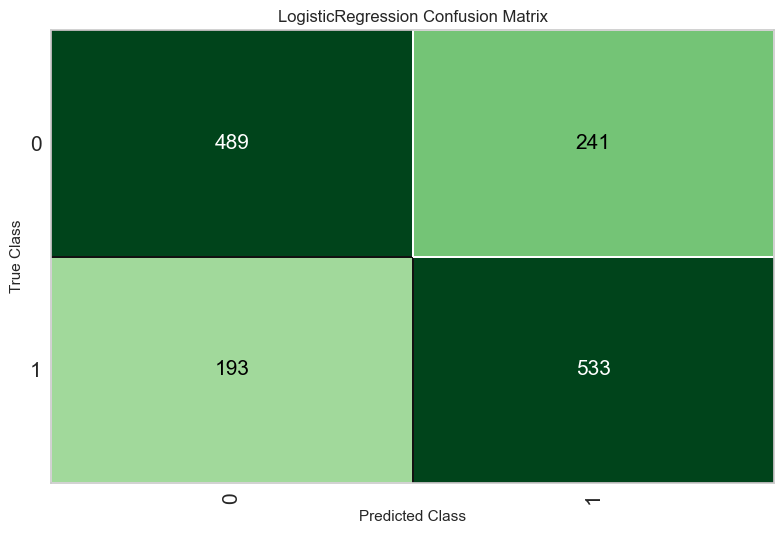

In [24]:
# plot confusion matrix
plot_model(tuned_model, plot = 'confusion_matrix')

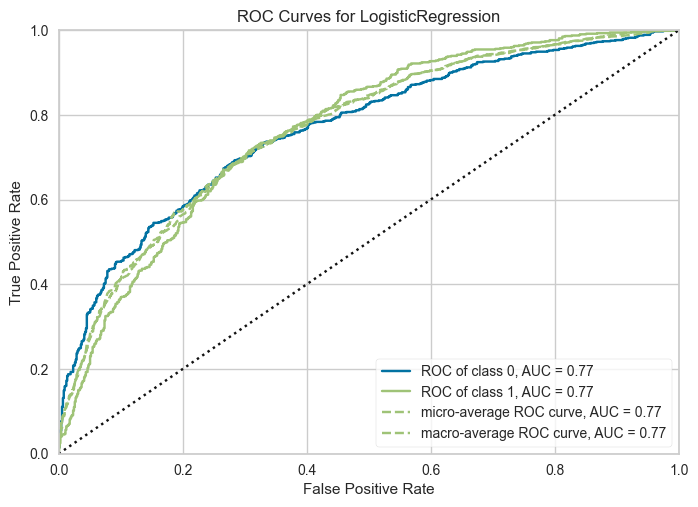

In [25]:
plot_model(tuned_model, plot = 'auc') # Erreur sur les matrices creuses, même en normalisant.

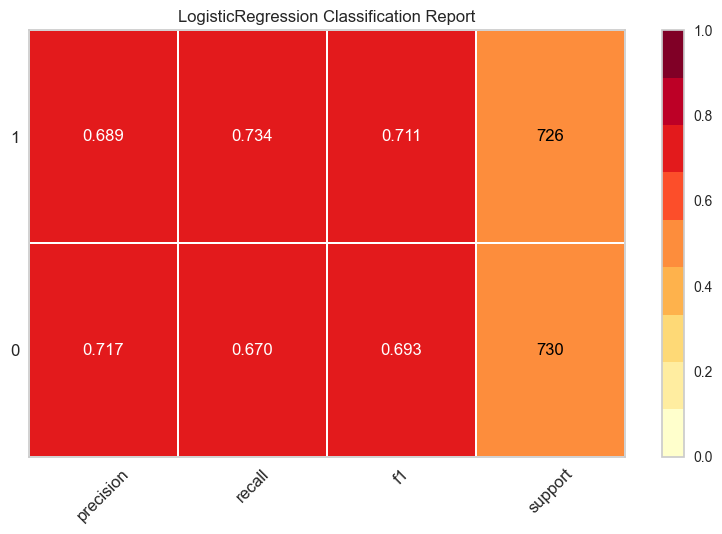

In [26]:
plot_model(tuned_model, plot = 'class_report') # boundary: Erreur sur les matrices creuses, même en normalisant.

In [27]:
pred_holdouts = predict_model(tuned_model)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7019,0.7666,0.7342,0.6886,0.7107,0.4039,0.4048


,00,0001s,00am,03,032010,04,0430,05,09,10,...,zilina,zipped,zombie,zomg,zone,zoo,zulu,target,prediction_label,prediction_score
3395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.9148
3396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.6683
3397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.8116
3398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9456
3399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9470


In [30]:
pred_holdouts.shape

(1456, 6379)

In [34]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['00', '0001s', '00am', '03',
                                             '032010', '04', '0430', '05', '09',
                                             '10', '100', '1000', '10010',
                                             '100bt', '100mi', '100mph',
                                             '10411', '105', '1057', '1080p',
                                             '10am', '10hrs', '10k', '10m',
                                             '10mbps', '10pm', '10x', '10x10',
                                             '11', '1130', ...],
                                    transformer=SimpleImputer(add_ind...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [35]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

# os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(tuned_model, PATH + "models" + os.sep + "best_model_CountVectorizer_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['00', '0001s', '00am', '03',
                                              '032010', '04', '0430', '05', '09',
                                              '10', '100', '1000', '10010',
                                              '100bt', '100mi', '100mph',
                                              '10411', '105', '1057', '1080p',
                                              '10am', '10hrs', '10k', '10m',
                                              '10mbps', '10pm', '10x', '10x10',
                                              '11', '1130', ...],
                                     transformer=SimpleImputer(add_ind...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('

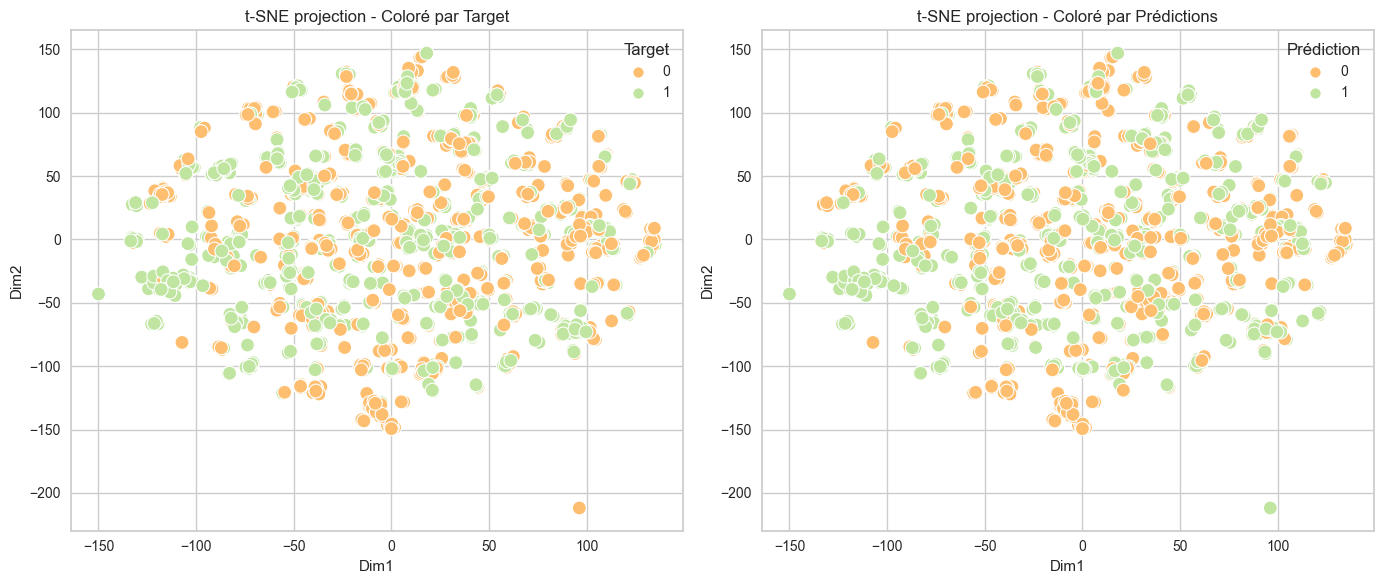

In [44]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Préparation des données : Extraire les colonnes à projeter
# X = pred_holdouts.drop(['target', 'prediction_label', 'prediction_score'], axis=1)
X = test_count.drop(['target'], axis=1)

# Si X est une matrice creuse (sparse), on la convertit en dense
if hasattr(X, "toarray"):  # Vérifier si les données sont creuses
    X = X.toarray()

# 2. Réduction de dimensionnalité avec TruncatedSVD avant t-SNE
svd = TruncatedSVD(n_components=50, random_state=42)  # Réduire à 50 dimensions
X_svd = svd.fit_transform(X)

# Alternative UMAP
# import umap
# reducer = umap.UMAP(n_components=50, random_state=42)
# X_umap = reducer.fit_transform(X)

# Alternative non linéaire
# from sklearn.decomposition import KernelPCA
# kpca = KernelPCA(n_components=50, kernel='rbf', gamma=0.1)  # Kernel PCA avec noyau RBF
# X_kpca = kpca.fit_transform(X)

# Réduction supervisée (LDA)
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# lda = LDA(n_components=1)
# X_lda = lda.fit_transform(X.to, pred_holdouts['target'])  # Utilisation des labels

# 3. Application de t-SNE avec le solveur arpack
tsne = TSNE(n_components=2, random_state=42, method='barnes_hut', n_iter=2000, perplexity=2, init="random", learning_rate=300)
X_tsne = tsne.fit_transform(X_svd)

# 4. Ajouter les vraies valeurs et les prédictions aux résultats t-SNE pour la visualisation
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['target'] = pred_holdouts['target'].values
tsne_df['prediction_label'] = pred_holdouts['prediction_label'].values

# 5. Création des graphes t-SNE colorés par les vraies valeurs et par les prédictions
plt.figure(figsize=(14, 6))

# Graphe à gauche: coloré par les vraies valeurs (target)
plt.subplot(1, 2, 1)
sns.scatterplot(x='Dim1', y='Dim2', hue='target', data=tsne_df, palette='Spectral', s=100)
plt.title('t-SNE projection - Coloré par Target')
plt.legend(title='Target', loc='best')

# Graphe à droite: coloré par les prédictions (prediction_label)
plt.subplot(1, 2, 2)
sns.scatterplot(x='Dim1', y='Dim2', hue='prediction_label', data=tsne_df, palette='Spectral', s=100)
plt.title('t-SNE projection - Coloré par Prédictions')
plt.legend(title='Prédiction', loc='best')

plt.tight_layout()
plt.show()


#### TFIdF

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
train_tfidf_sparse = tfidf.fit_transform(train_df['preprocessed_text'])
test_tfidf_sparse = tfidf.transform(test_df['preprocessed_text'])

In [50]:
import scipy.sparse
train_tfidf = pd.DataFrame.sparse.from_spmatrix(train_tfidf_sparse, columns=tfidf.get_feature_names_out())
test_tfidf = pd.DataFrame.sparse.from_spmatrix(test_tfidf_sparse, columns=tfidf.get_feature_names_out())

In [51]:
from scipy.sparse import csr_matrix, hstack
train_tfidf["target"] = y_train.values
test_tfidf["target"] = y_test.values

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s_tf = setup(data=train_tfidf, target='target', test_data=test_tfidf, session_id = 123, index=False, use_gpu=True)

In [53]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()


In [54]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [55]:
# compare baseline models and returns the best 6 ones
best_models_tf = compare_models(sort='Precision', n_select=6)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7225,0.8009,0.7364,0.7163,0.7257,0.4452,0.4460,4.1050
ridge,Ridge Classifier,0.7060,0.7875,0.7163,0.7015,0.7083,0.4122,0.4130,4.0730
rf,Random Forest Classifier,0.7016,0.7817,0.7365,0.6874,0.7103,0.4035,0.4054,4.7270
gbc,Gradient Boosting Classifier,0.6748,0.7568,0.6437,0.6859,0.6630,0.3496,0.3511,5.1940
et,Extra Trees Classifier,0.7125,0.7933,0.7867,0.6846,0.7316,0.4254,0.4309,4.6500
svm,SVM - Linear Kernel,0.6863,0.7555,0.6956,0.6830,0.6887,0.3727,0.3734,4.0880
lightgbm,Light Gradient Boosting Machine,0.6854,0.7617,0.6939,0.6810,0.6866,0.3710,0.3719,4.1140
catboost,CatBoost Classifier,0.6984,0.7745,0.7476,0.6800,0.7115,0.3970,0.3999,42.1630
ada,Ada Boost Classifier,0.6495,0.7376,0.6696,0.6521,0.6464,0.2990,0.3159,4.4850
knn,K Neighbors Classifier,0.6510,0.7064,0.6785,0.6427,0.6597,0.3020,0.3029,4.1360


In [56]:
# Amélioration du meilleur modèle (logistic regression)
tuned_model_tf = tune_model(estimator=best_models_tf[0], 
                         optimize="Precision", choose_better=True,
                         verbose=False)

In [57]:
tuned_model_tf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

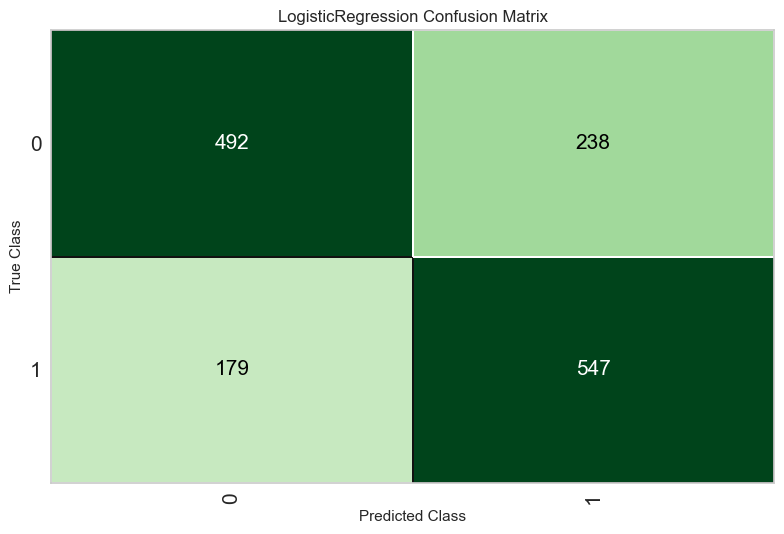

In [58]:
# plot confusion matrix
plot_model(tuned_model_tf, plot = 'confusion_matrix')

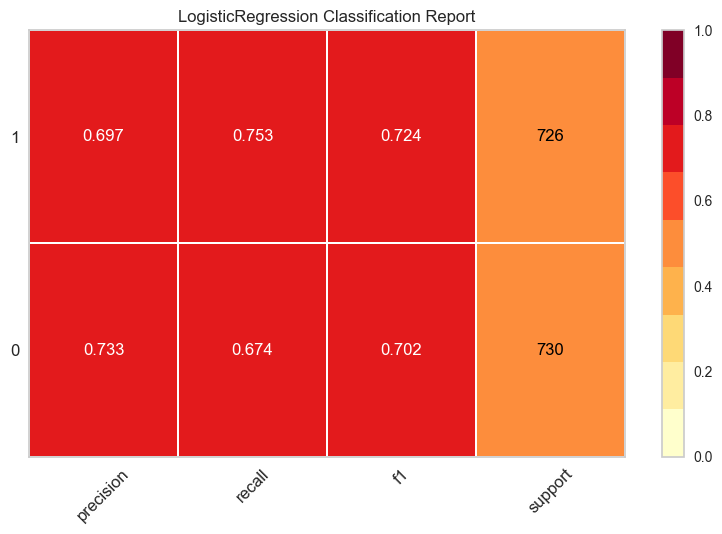

In [59]:
plot_model(tuned_model_tf, plot = 'class_report')

In [60]:
pred_holdouts_tf = predict_model(tuned_model_tf)
pred_holdouts_tf.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7136,0.7884,0.7534,0.6968,0.7240,0.4273,0.4287


,00,05,10,10 day,10 hour,10 min,100,10am,10pm,11,...,youu,yr,yucky,yum,yup,yup go,zero,target,prediction_label,prediction_score
3395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7587
3396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5607
3397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8066
3398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7605
3399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7219


In [61]:
# Finalize the model (train on the entire dataset)
finalize_model(tuned_model_tf)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['00', '05', '10', '10 day',
                                             '10 hour', '10 min', '100', '10am',
                                             '10pm', '11', '11 30', '11 going',
                                             '11 hour', '12', '12 30',
                                             '12 hour', '12 week', '125', '13',
                                             '14', '14 hour', '14 hr', '15',
                                             '15 hour', '15 min', '15 minute',
                                             '150', '150 dollar', '17', '18', ...],
                                    transformer=SimpleImpute...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [62]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

# os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(tuned_model_tf, PATH + "models" + os.sep + "best_model_TFIdF_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['00', '05', '10', '10 day',
                                              '10 hour', '10 min', '100', '10am',
                                              '10pm', '11', '11 30', '11 going',
                                              '11 hour', '12', '12 30',
                                              '12 hour', '12 week', '125', '13',
                                              '14', '14 hour', '14 hr', '15',
                                              '15 hour', '15 min', '15 minute',
                                              '150', '150 dollar', '17', '18', ...],
                                     transformer=SimpleImpute...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
    